<a href="https://colab.research.google.com/github/GuysBarash/ML_Workshop/blob/main/BayesianNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [115]:
!pip install pomegranate
!apt install libgraphviz-dev
!pip install pygraphviz
from IPython.display import clear_output 
clear_output()

In [116]:
import pomegranate as pmgrnt

import matplotlib.pyplot as plt
import seaborn
seaborn.set_style('whitegrid')
import graphviz

# Probabilities

Water source

In [117]:
chance_of_rain = 0.31 #@param {type: "slider", min: 0.0, max: 1.0, step:0.01}
chance_of_car_wash = 0.1 #@param {type: "slider", min: 0.0, max: 1.0, step:0.01}

wet prob

In [118]:
wet_on_full = 1.0 #@param {type: "slider", min: 0.0, max: 1.0, step:0.01}
wet_given_rain = 0.8 #@param {type: "slider", min: 0.0, max: 1.0, step:0.01}
wet_given_car_washed = 0.4 #@param {type: "slider", min: 0.0, max: 1.0, step:0.01}
wet_on_empty = 0.0 #@param {type: "slider", min: 0.0, max: 1.0, step:0.01}

Slipping prob

In [119]:
slip_on_wet = 0.6 #@param {type: "slider", min: 0.0, max: 1.0, step:0.01}
slip_on_dry = 0.05 #@param {type: "slider", min: 0.0, max: 1.0, step:0.01}

# Build model

Define distributions

In [120]:
rain = pmgrnt.DiscreteDistribution({True: chance_of_rain, False: 1 - chance_of_rain})
car_washed = pmgrnt.DiscreteDistribution({True: chance_of_car_wash, False: 1 - chance_of_car_wash})

is_wet = pmgrnt.ConditionalProbabilityTable(
    [
        [True, True, True, wet_on_full],
        [True, True, False, 1 - wet_on_full],

        [True, False, True, wet_given_rain],
        [True, False, False, 1 - wet_given_rain],

        [False, True, True, wet_given_car_washed],
        [False, True, False, 1 - wet_given_car_washed],

        [False, False, True, wet_on_empty],
        [False, False, False, 1 - wet_on_empty],

    ],
    [rain, car_washed],
)

slipped = pmgrnt.ConditionalProbabilityTable(
    [
        [True, True, slip_on_wet],
        [True, False, 1 - slip_on_wet],

        [False, True, slip_on_dry],
        [False, False, 1 - slip_on_dry],

    ],
    [is_wet],
)

define nodes

In [121]:
rain_node = pmgrnt.Node(rain, name="Rain")
car_node = pmgrnt.Node(car_washed, name="Car washed")
wet_node = pmgrnt.Node(is_wet, name="Wet floor")
slip_node = pmgrnt.Node(slipped, name="Slipped")

build model

In [122]:
model = pmgrnt.BayesianNetwork("Slippery driveway")
model.add_states(rain_node, car_node, wet_node, slip_node)
model.add_edge(rain_node, wet_node)
model.add_edge(car_node, wet_node)
model.add_edge(wet_node, slip_node)
model.bake()

# Visualization

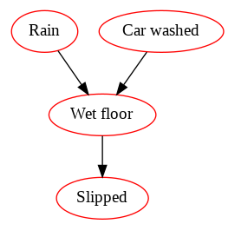

In [123]:
model.plot()

# Proof of independence

In [124]:
model.predict_proba({'Rain':True,'Car washed':True,"Wet floor":True})

array([True, True, True, {
                             "class" : "Distribution",
                             "dtype" : "bool",
                             "name" : "DiscreteDistribution",
                             "parameters" : [
                                 {
                                     "False" : 0.4000000000000001,
                                     "True" : 0.6
                                 }
                             ],
                             "frozen" : false
                         }                                        ],
      dtype=object)

In [125]:
for slip in [True, False]:
  slip_str = ''
  if not slip:
    slip_str = 'not '

  for wet_floor in [True,False]:
    wet_str = ''
    if not wet_floor:
      wet_str = 'out'

    slip_chance = model.predict_proba({"Wet floor":wet_floor})[-1].parameters[0][slip]
    print(f"Chance of {slip_str}Slipping with{wet_str} wet floor: {slip_chance:>.3f}")

    prob_sum = 0
    for rain_checker in [True,False]:
      rmsg = ''
      if rain_checker:
        rmsg += f"({'RAIN':^10})+"
      else:
        rmsg += f"({'NO RAIN':^10})+"
      for car_checker in [True,False]:
        cmsg = rmsg
        if car_checker:
          cmsg += f"({'CAR WASHED':^20})"
        else:
          cmsg += f"({'CAR NOT WASHED':^20})"

        wmsg = cmsg
        if wet_floor:
          wmsg += f"+({'WET FLOOR':^15})"
        else:
          wmsg += f"+({'FLOOR NOT WET':^15})"

    

        is_legal = model.predict_proba({"Rain":rain_checker,"Car washed":car_checker})[-2].parameters[0][wet_floor] > 0
        slip_chance = model.predict_proba({"Rain":rain_checker,
                                          "Car washed":car_checker,
                                          "Wet floor":wet_floor,
                                          })[-1].parameters[0][slip]

        if is_legal:
          pmsg = f"-> Chance of slipping {slip_chance:>.3f}"
        else:
          pmsg = f"-> Illegal combination"
        msg = wmsg + pmsg
        print(msg)
    print("     ")
  print("              ")    

          


Chance of Slipping with wet floor: 0.600
(   RAIN   )+(     CAR WASHED     )+(   WET FLOOR   )-> Chance of slipping 0.600
(   RAIN   )+(   CAR NOT WASHED   )+(   WET FLOOR   )-> Chance of slipping 0.600
( NO RAIN  )+(     CAR WASHED     )+(   WET FLOOR   )-> Chance of slipping 0.600
( NO RAIN  )+(   CAR NOT WASHED   )+(   WET FLOOR   )-> Illegal combination
     
Chance of Slipping without wet floor: 0.050
(   RAIN   )+(     CAR WASHED     )+( FLOOR NOT WET )-> Illegal combination
(   RAIN   )+(   CAR NOT WASHED   )+( FLOOR NOT WET )-> Chance of slipping 0.050
( NO RAIN  )+(     CAR WASHED     )+( FLOOR NOT WET )-> Chance of slipping 0.050
( NO RAIN  )+(   CAR NOT WASHED   )+( FLOOR NOT WET )-> Chance of slipping 0.050
     
              
Chance of not Slipping with wet floor: 0.400
(   RAIN   )+(     CAR WASHED     )+(   WET FLOOR   )-> Chance of slipping 0.400
(   RAIN   )+(   CAR NOT WASHED   )+(   WET FLOOR   )-> Chance of slipping 0.400
( NO RAIN  )+(     CAR WASHED     )+(   WET